# Medical image processing Homework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision
from torch import nn
from sklearn.model_selection import train_test_split

In [2]:
# Paths
train_img_dir = "/kaggle/input/dataset/dataset/train_imgs"
train_label_dir = "/kaggle/input/dataset/dataset/train_lbs"
test_img_dir = "/kaggle/input/dataset/dataset/test_imgs"

## DataLoader

In [3]:
 # Define the dataset class
class CustomDataset(Dataset):
        def __init__(self, img_dir, label_dir=None, transform=None):
            self.img_dir = img_dir
            self.label_dir = label_dir
            self.transform = transform
            self.images = os.listdir(img_dir)

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_name = self.images[idx]
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            
            if self.label_dir:
                label_name = img_name.replace('.png', '.npy')
                label_path = os.path.join(self.label_dir, label_name)
                label = np.load(label_path)
                #label_resized = Image.fromarray(label).resize((256, 256), resample=Image.NEAREST)
                label_tensor = torch.from_numpy(np.array(label)).long()
            else:
                label_tensor = None
                
            if self.transform:
                image = self.transform(image)

            return image, label_tensor

def create_data_loaders(train_img_dir, train_label_dir, test_img_dir, batch_size=32, validation_split=0.2):
    """
    Create DataLoaders for train, validation, and test sets.

    Parameters:
        train_img_dir (str): Directory containing the training images.
        train_label_dir (str): Directory containing the training labels.
        test_img_dir (str): Directory containing the test images.
        batch_size (int): Batch size for the DataLoader.
        validation_split (float): Proportion of the training data to use as validation.

    Returns:
        train_loader, val_loader, test_loader (DataLoader): DataLoaders for the train, validation, and test sets.
    """
    transform = transforms.Compose([
        #transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

   
    # Load dataset and split into train and validation indices
    full_dataset = CustomDataset(train_img_dir, train_label_dir, transform=transform)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=validation_split, random_state=42)

    # Create subsets and corresponding DataLoaders
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader= create_data_loaders(train_img_dir=train_img_dir,
                                                            train_label_dir=train_label_dir,
                                                            test_img_dir=test_img_dir,
                                                            batch_size=32,
                                                            validation_split=0.2)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of training samples:", len(train_loader.dataset))
print("Number of validation samples:", len(val_loader.dataset))

Number of training batches: 23
Number of validation batches: 6
Number of training samples: 713
Number of validation samples: 179


In [4]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))  # Sort for consistent ordering

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # Return image and filename

transform3 = transforms.Compose([
    transforms.ToTensor()
])

test_dataset_instance = TestDataset(test_img_dir, transform=transform3)
test_loader3 = DataLoader(test_dataset_instance, batch_size=32, shuffle=False)

print("Number of batches in Test Loader:", len(test_loader3))
for images, filenames in test_loader3:
    print(f'Image batch shape: {images.shape}')
    break

Number of batches in Test Loader: 5
Image batch shape: torch.Size([32, 3, 224, 224])


## Model

In [5]:
#Evaluation Metrics
def compute_iou(preds, labels, num_classes):
    """
    Compute IoU for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        iou_list (list): List of IoU for each class
    """
    iou_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        union = (pred_inds | target_inds).sum().float().item()

        if union == 0:
            iou = float('nan')  # Avoid division by zero
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

def compute_dice(preds, labels, num_classes):
    """
    Compute Dice Coefficient for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        dice_list (list): List of Dice Coefficient for each class
    """
    dice_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        pred_sum = pred_inds.sum().float().item()
        target_sum = target_inds.sum().float().item()

        if pred_sum + target_sum == 0:
            dice = float('nan')  # Avoid division by zero
        else:
            dice = (2 * intersection) / (pred_sum + target_sum)
        dice_list.append(dice)
    return dice_list


In [6]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)  # Apply softmax for multiclass segmentation
        targets = nn.functional.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2)
        intersection = (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [7]:
# Model definition
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 5, kernel_size=(1, 1))
nn.init.xavier_uniform_(model.classifier[4].weight)  # Initialize the new layer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

# Loss and optimizer
#criterion = DiceLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 93.0MB/s] 


cuda


In [8]:
# Model training 
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, num_classes=5, device='cuda'):
    """
    Train a segmentation model and compute metrics (IoU and Dice).
    
    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of training epochs.
        num_classes (int): Number of segmentation classes.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        history (dict): Dictionary containing loss and metrics for each epoch.
    """
    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_dice': [], 'val_dice': []
    }

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        train_iou_scores = []
        train_dice_scores = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)  # Predicted labels
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # Compute metrics
            iou = compute_iou(preds.cpu(), labels.cpu(), num_classes)
            dice = compute_dice(preds.cpu(), labels.cpu(), num_classes)
            train_iou_scores.append(iou)  # Append IoU for all classes
            train_dice_scores.append(dice)

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_iou_scores = []
        val_dice_scores = []

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Forward pass
                val_outputs = model(val_images)['out']
                val_preds = torch.argmax(val_outputs, dim=1)  # Predicted labels
                val_loss = criterion(val_outputs, val_labels)

                running_val_loss += val_loss.item()

                # Compute metrics
                val_iou = compute_iou(val_preds.cpu(), val_labels.cpu(), num_classes)
                val_dice = compute_dice(val_preds.cpu(), val_labels.cpu(), num_classes)
                val_iou_scores.append(val_iou)
                val_dice_scores.append(val_dice)

        # Calculate average losses
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)

        # Compute mean metrics across batches
        train_iou_scores_np = np.array(train_iou_scores)  # Shape: (num_batches, num_classes)
        train_dice_scores_np = np.array(train_dice_scores)
        val_iou_scores_np = np.array(val_iou_scores)
        val_dice_scores_np = np.array(val_dice_scores)

        # Compute average IoU and Dice for each class
        epoch_train_iou = np.nanmean(train_iou_scores_np, axis=0)  # Shape: (num_classes,)
        epoch_train_dice = np.nanmean(train_dice_scores_np, axis=0)
        epoch_val_iou = np.nanmean(val_iou_scores_np, axis=0)
        epoch_val_dice = np.nanmean(val_dice_scores_np, axis=0)

        # Record losses and metrics
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_iou'].append(epoch_train_iou)
        history['val_iou'].append(epoch_val_iou)
        history['train_dice'].append(epoch_train_dice)
        history['val_dice'].append(epoch_val_dice)

        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        print(f'Train Mean IoU: {np.nanmean(epoch_train_iou):.4f}, Val Mean IoU: {np.nanmean(epoch_val_iou):.4f}')
        print(f'Train Mean Dice: {np.nanmean(epoch_train_dice):.4f}, Val Mean Dice: {np.nanmean(epoch_val_dice):.4f}')

    return history


# Train the model
history = train_model(model, train_loader, val_loader,criterion, optimizer)

# save model
print("saving model")
torch.save(model.state_dict(), 'model.pth')

Epoch [1/20], Train Loss: 0.4055, Validation Loss: 0.1283
Train Mean IoU: 0.4247, Val Mean IoU: 0.5225
Train Mean Dice: 0.4867, Val Mean Dice: 0.6096
Epoch [2/20], Train Loss: 0.0706, Validation Loss: 0.0516
Train Mean IoU: 0.6588, Val Mean IoU: 0.6962
Train Mean Dice: 0.7183, Val Mean Dice: 0.7429
Epoch [3/20], Train Loss: 0.0427, Validation Loss: 0.0370
Train Mean IoU: 0.7131, Val Mean IoU: 0.7586
Train Mean Dice: 0.7655, Val Mean Dice: 0.8254
Epoch [4/20], Train Loss: 0.0316, Validation Loss: 0.0288
Train Mean IoU: 0.8026, Val Mean IoU: 0.8206
Train Mean Dice: 0.8731, Val Mean Dice: 0.8890
Epoch [5/20], Train Loss: 0.0256, Validation Loss: 0.0258
Train Mean IoU: 0.8421, Val Mean IoU: 0.8316
Train Mean Dice: 0.9064, Val Mean Dice: 0.8995
Epoch [6/20], Train Loss: 0.0219, Validation Loss: 0.0234
Train Mean IoU: 0.8639, Val Mean IoU: 0.8305
Train Mean Dice: 0.9223, Val Mean Dice: 0.8961
Epoch [7/20], Train Loss: 0.0195, Validation Loss: 0.0200
Train Mean IoU: 0.8738, Val Mean IoU: 0.85

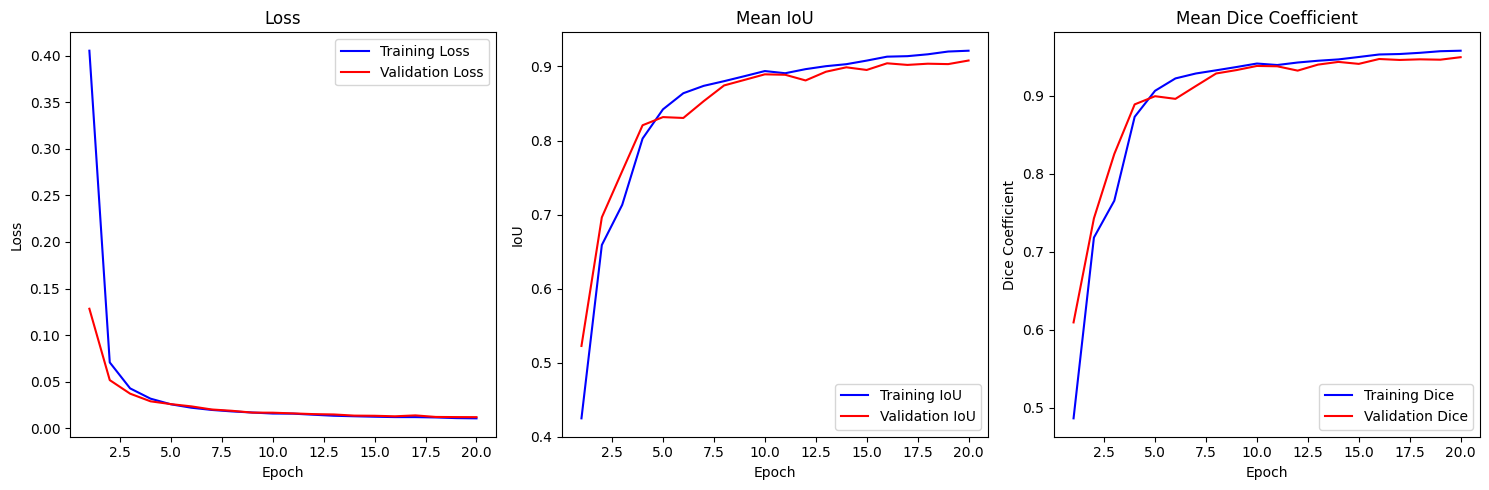

In [9]:
# Plot training history

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Mean IoU
    train_mean_iou = [np.nanmean(iou) for iou in history['train_iou']]
    val_mean_iou = [np.nanmean(iou) for iou in history['val_iou']]

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_mean_iou, 'b', label='Training IoU')
    plt.plot(epochs, val_mean_iou, 'r', label='Validation IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Plot Mean Dice Coefficient
    train_mean_dice = [np.nanmean(dice) for dice in history['train_dice']]
    val_mean_dice = [np.nanmean(dice) for dice in history['val_dice']]

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_mean_dice, 'b', label='Training Dice')
    plt.plot(epochs, val_mean_dice, 'r', label='Validation Dice')
    plt.title('Mean Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history)

## Model Evaluation

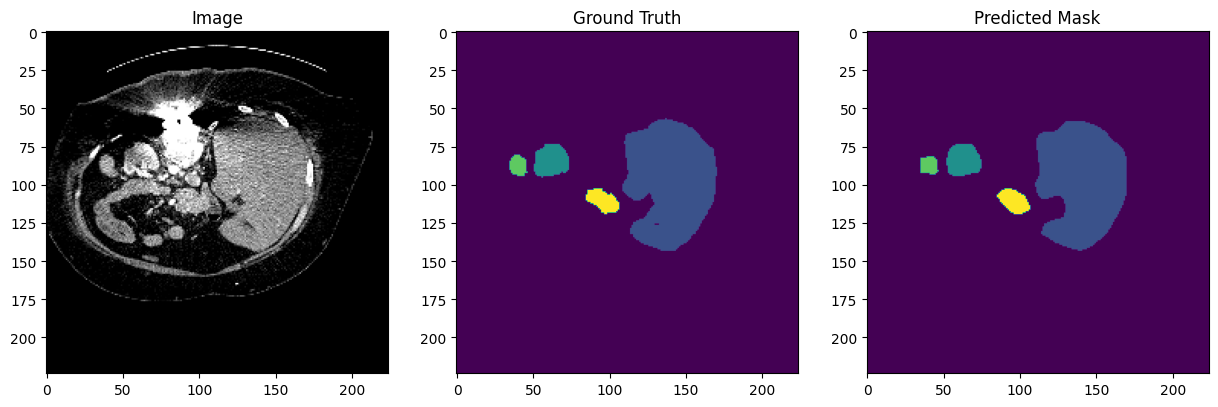

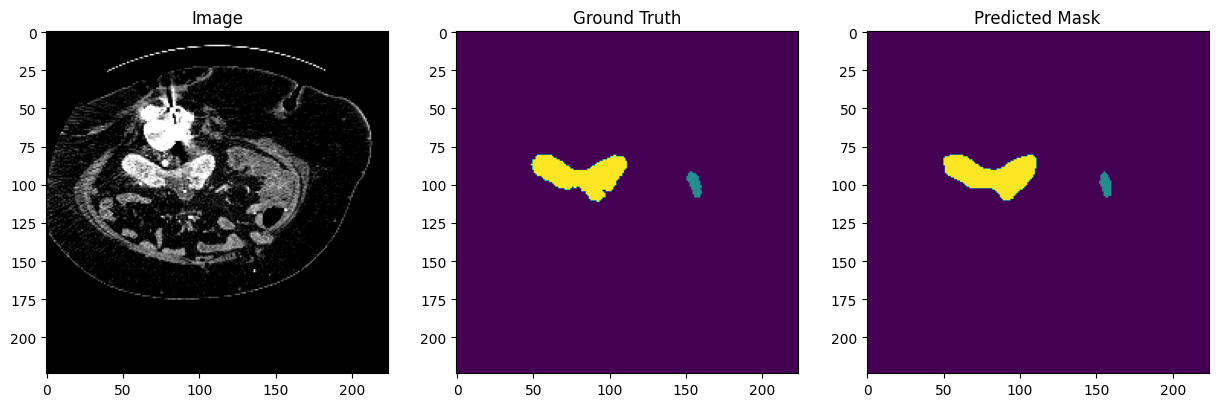

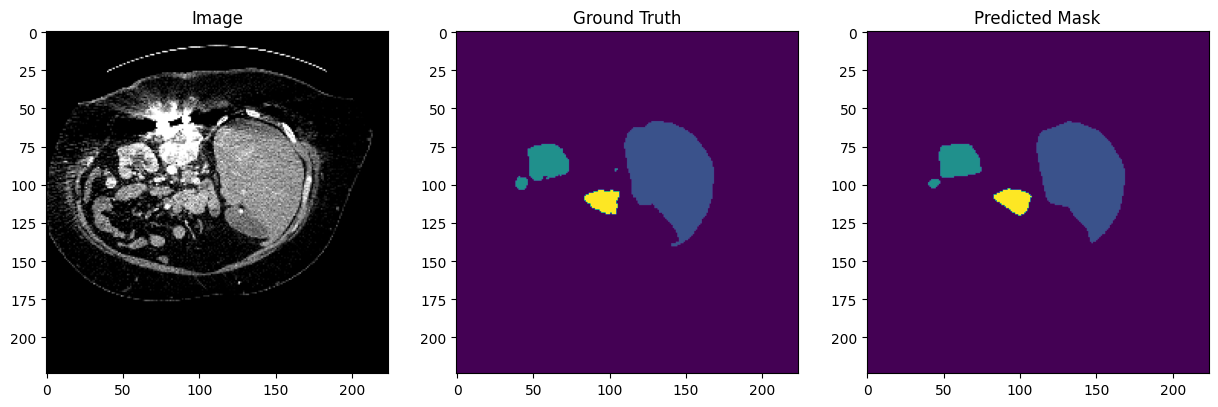

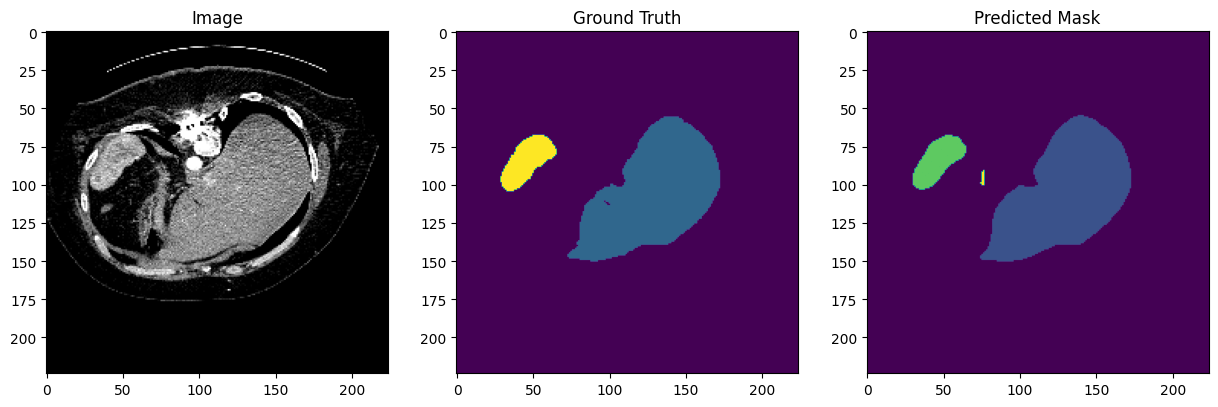

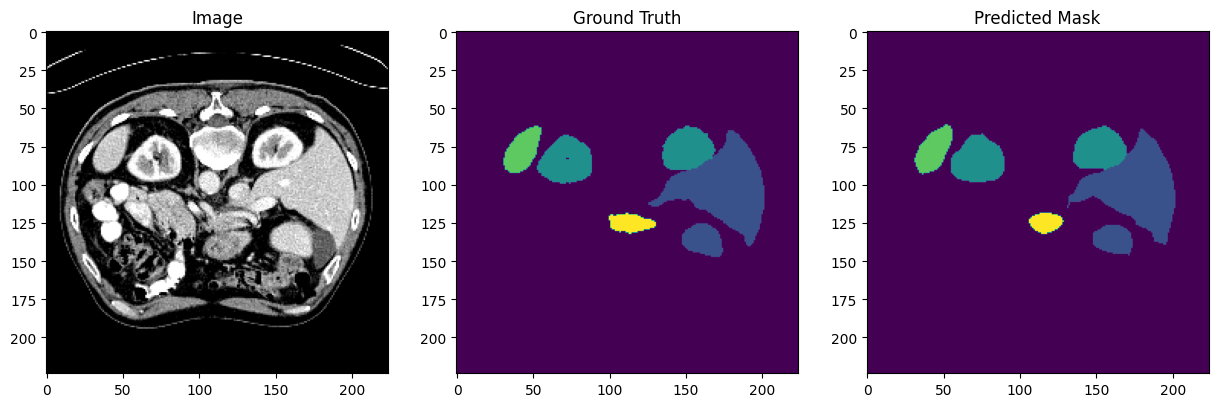

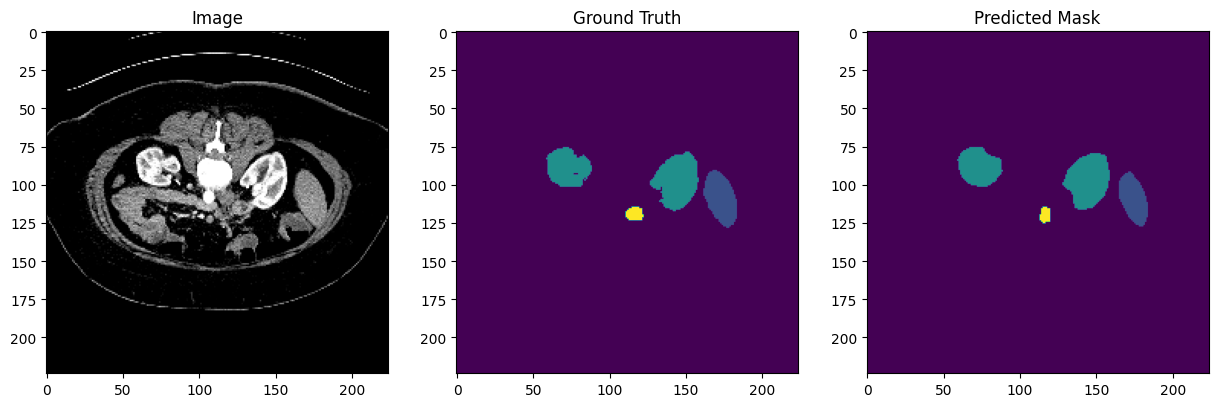

In [12]:
i = 0
# Iterate through validation loader
for val_images, val_labels in val_loader:
    # Select the i-th image and label
    val_img = val_images[i]
    val_label = val_labels[i]

    # Prepare image for model
    val_img = val_img.unsqueeze(0).to(device)

    # Forward pass
    outputs = model(val_img)['out']

    # Get predictions (argmax over classes)
    predictions = outputs.argmax(dim=1).squeeze(0).cpu().numpy()

    # Convert image and ground truth to numpy for visualization
    val_img_np = val_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    # Plot image, ground truth, and predictions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(val_img_np, cmap ='gray')
    axs[0].set_title('Image')
    axs[1].imshow(val_label_np)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(predictions)
    axs[2].set_title('Predicted Mask')
    plt.show()

    # Stop after visualizing 10 images
    i += 1
    if i == 10:
        break


In [13]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from tqdm import tqdm

# Define classes for each organ in your dataset
classes = ["Liver", "Kidney", "Spleen", "Pancreas"]

# Store the results
results = {
    "Target": [],
    "F1-score": [],
    "Recall": [],
    "Precision": [],
    "Dice": [],
    "IoU": []
}

print("Loop")
for class_idx, class_name in enumerate(classes):

    y_true = []
    y_pred = []
    # Loop through the images and labels in your validation dataset
    for i, (image, label) in enumerate(tqdm(val_loader, desc=f"Processing {class_name}")):
        with torch.no_grad():  # Disable gradient calculations
            image = image.to(device)  # Move image to the same device as the model
            label = label.to(device)  # Move label to the same device as the model
            # Get the model predictions
            output = model(image)['out']
            predictions = torch.argmax(output, dim=1)
            # Flatten arrays to compare each pixel
            y_true.extend((label == class_idx).cpu().numpy().flatten())
            y_pred.extend((predictions == class_idx).cpu().numpy().flatten())

        # Clear CUDA cache
        torch.cuda.empty_cache()

    # Convert y_true and y_pred to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics for the current class
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Dice coefficient is equivalent to F1-score for binary classification
    dice = f1

    # Calculate IoU
    iou = jaccard_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Append results to the table
    results["Target"].append(class_name)
    results["F1-score"].append(f1)
    results["Recall"].append(recall)
    results["Precision"].append(precision)
    results["Dice"].append(dice)
    results["IoU"].append(iou)
    
    # Delete lists to free up memory after each class calculation
    del y_true, y_pred

# Convert results to a DataFrame for easy display
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

Loop


Processing Pancreas: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


     Target  F1-score    Recall  Precision      Dice       IoU
0     Liver  0.997533  0.998349   0.996718  0.997533  0.995077
1    Kidney  0.978124  0.967664   0.988813  0.978124  0.957185
2    Spleen  0.954568  0.952957   0.956184  0.954568  0.913084
3  Pancreas  0.963479  0.942087   0.985866  0.963479  0.929532


In [14]:
# Example of evaluation metric calculation (Dice score)
def dice_score(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    preds_one_hot = nn.functional.one_hot(preds, num_classes=num_classes).permute(0, 3, 1, 2)
    
    # Ensure both preds_one_hot and targets_one_hot have the same type and device
    preds_one_hot = preds_one_hot.type_as(targets)
    
    targets_one_hot = nn.functional.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)
    
    intersection = (preds_one_hot * targets_one_hot).sum(dim=(2, 3))
    union = preds_one_hot.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + 1.0) / (union + 1.0)
    return dice.mean().item()

# Compute dice score on test set
total_dice = 0.0
count = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        total_dice += dice_score(outputs, masks)
        count += 1

average_dice = total_dice / count
print(f'Average Dice Score on Val Set: {average_dice:.4f}')

Average Dice Score on Val Set: 0.9418


## Saving Results

In [15]:
def rle_encode(mask):
    """Run-length encoding for a 2D mask."""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to generate the CSV format for submission
def create_submission_csv(test_loader, model, device, output_csv_path='DeepLabv3.csv'):
    model.eval()
    submission_data = []
    with torch.no_grad():
        for i, (images, filenames) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)['out']
            predictions = outputs.argmax(dim=1).cpu().numpy()  # Get predicted class masks

            # Generate Id and RLE for each image
            for idx, (filename, pred_mask) in enumerate(zip(filenames, predictions)):
                base_name = filename.split('.')[0]  # Extract the base name without extension
                for class_id in range(5):  # Classes: 0 (Background), 1 (Liver), 2 (Kidney), 3 (Spleen), 4 (Pancreas)
                    mask = (pred_mask == class_id).astype(np.uint8)
                    rle = rle_encode(mask) if mask.sum() > 0 else ''  # Encode to RLE if non-empty mask
                    submission_data.append([f"{base_name}_{class_id}", rle])

    # Create DataFrame and save to CSV
    submission_df = pd.DataFrame(submission_data, columns=['Id', 'Predicted'])
    submission_df.to_csv(output_csv_path, index=False)
    print(f"Submission CSV created at {output_csv_path}")

# Example usage
create_submission_csv(test_loader3, model, device)

Submission CSV created at DeepLabv3.csv
